# **Tensor Networks + Density Matrix Renormalization Group for Solving Weighted Max-Cut**

#  🧠 **Solving Max-Cut Using Tensor Network Methods** 🧠

Welcome to this notebook! Here, we demonstrate how to use **Tensor Network** methods to solve the **Weighted Max-Cut** problem.

This guide will walk you step by step through the process:

1. **Upload your Max-Cut instances**: Provide your problem data.
2. **Create a Tensor Network**: Generate a TN representation based on your instance.
3. **Apply the DMRG algorithm**: Solve the problem efficiently using tensor network optimization.
4. **Obtain the solution**: Retrieve the result for your Max-Cut instance.

---

**Contact**  
This notebook was created by **Aitor Morais** and **Izaskun Oregui**.  
For suggestions, comments, or issues, feel free to reach out to us via email:  
- **Aitor Morais**: [aitor.morais@deusto.es](mailto:aitor.morais@deusto.es)  
- **Izaskun Oregi**: [izaskun.oregui@tecnalia.com](mailto:izaskun.oregui@tecnalia.com)

---


Let's get started! 😊




# 📥**Expected Inputs and Outputs**📤

### **Input**
This notebook expects the following input:
1. A **square matrix** representing the Max-Cut instance.

---

### **Output**
The output will include:
1. The **energy** of the solution.
2. The corresponding **bitstring** that defines the cut.

---
## <font color='red'><b>⚠️**WARNING**⚠️</b></font>
We assume the input matrix is **symmetric**.  

If it is not symmetric, you must add the lower triangular part to the upper part.




# ⚙️ **Prepare the Environment**⚙️

### **File Source**
You have **two options** to provide the input matrix for this notebook:

1. **Upload your own matrix**: Provide a square matrix file from your local system.  
2. **Use a matrix provided by us**: Select from example matrices included in this notebook to get started quickly.

---

Let’s set up the environment and choose your file source! 📂



# 🗂️**Option 1: Upload Your Own Matrix**🗂️



To use your own matrix in this notebook, you first need to save it as an `.npz` file. Follow these steps:

1. **Prepare Your Matrix**:
   - Ensure your matrix is square, as required for the Max-Cut problem.
   - If the lower triangular part of your matrix is not all zeros, symmetrize it by summing the lower triangular part to the upper triangular part. Use the following code:
     ```python
     import numpy as np

     # Example: Replace with your own matrix
     my_matrix = np.array([
         [0, 1, 2],
         [3, 0, 4],
         [5, 6, 0]
     ])

     # Symmetrize the matrix
     symmetric_matrix = np.triu(my_matrix) + np.triu(my_matrix, k=1).T

     # Set the lower triangular part to zero
     symmetric_matrix = np.triu(symmetric_matrix)
     #print("Symmetrized matrix:")
     #print(symmetric_matrix)
     shape = symmetric_matrix.shape[0]
     ```

2. **Save the Matrix as `.npz`**:
   - The matrix must be saved with the key **`matrix`**. This key is required for the notebook to correctly load your data.
   - Use the following code to save your matrix:
     ```python
     # Save as .npz with the required key 'matrix'
     np.savez(f"MaxCut_{shape}.npz", matrix=symmetric_matrix)
     print("Matrix saved as my_matrix.npz with key 'matrix'")
     ```

3. **Upload the File**:
   - Run the cell below to upload your `.npz` file to this notebook.

---

In [ ]:
import numpy as np
#@markdown ##Play the cell to create a random matrix
# Example: Replace with your own matrix


# Generate a random 6x6 matrix with integers between 1 and 10
matrix = np.random.randint(1, 11, size=(5, 5))



# Set the diagonal elements to 0
np.fill_diagonal(matrix, 0)

# Print the matrix
print(matrix)

# Symmetrize the matrix
symmetric_matrix = np.tril(matrix, k=-1).T+np.triu(matrix)

# Set the lower triangular part to zero
symmetric_matrix = np.triu(symmetric_matrix)
print("Symmetrized matrix:")
print(symmetric_matrix)
shape = symmetric_matrix.shape[0]
# Save as .npz with the required key 'matrix'
np.savez(f"MaxCut_{shape}.npz", matrix=symmetric_matrix)
print("Matrix saved as my_matrix.npz with key 'matrix'")

[[ 0  6  6 10  1]
 [10  0  8  9  6]
 [ 6  2  0  2  6]
 [ 7  8  7  0  5]
 [ 7  3  9  2  0]]
Symmetrized matrix:
[[ 0 16 12 17  8]
 [ 0  0 10 17  9]
 [ 0  0  0  9 15]
 [ 0  0  0  0  7]
 [ 0  0  0  0  0]]
Matrix saved as my_matrix.npz with key 'matrix'


In [ ]:
#@markdown ##Play the cell to upload local file
from google.colab import files
!mkdir -p /content/data
%cd /content/data
uploaded = files.upload()
%cd /content

/content/data


/content


In [ ]:
#@title Select the number of nodes
#@markdown Enter the number of nodes for your Max-Cut problem:

nodes_selected = 5  #@param {type:"integer"}

# Validate the input
if nodes_selected <= 0:
    raise ValueError("The number of nodes must be a positive integer.")
else:
    print(f"The selected number of nodes is: {nodes_selected}")


The selected number of nodes is: 5


# 🗂️**Option 2: Use Our Matrix**🗂️

In [ ]:
#@markdown ## **Download the dataset from Google Drive**

import os
import gdown

# Cambiar al directorio de trabajo
os.chdir('/content/')

# URL del archivo comprimido en Drive
gdown.download("https://drive.google.com/uc?id=1QZVYcLzVbarjOAxSYQc32J_PrBKSxkza", "data.zip", quiet=True)

# Descomprimir el archivo
!unzip -q data.zip
!rm data.zip

print("Dataset downloaded and unzipped under /content/data")



Dataset downloaded and unzipped under /content/data


In [ ]:
#@title **Select the number of nodes**
Maxcut_nodes = ['10', '20', '40', '50', '60', '80', '90',
                '100', '120', '140', '150', '170', '200', '220', '250']

nodes_selected = "10"  #@param ["10","20","40","50","60","80","90","100","120","140","150","170","200","220","250"]
#@markdown Press ▶️ to save your selection.

print(f"You have selected: {nodes_selected}")



You have selected: 10


## 🔄**Load DMRG and TN generator**🔄



In [ ]:
#@markdown ## **Importing necessary libraries**
from typing import Callable, Dict, List, Tuple, Any
import numpy as np
from scipy.sparse.linalg import eigsh
import time
import networkx as nx
import matplotlib.pyplot as plt


### DMRG

In [ ]:
# DMRG
#@markdown ## **Load DMRG**

def ZipperLeft(Tl: np.ndarray, Mb: np.ndarray, O: np.ndarray, Mt: np.ndarray) -> np.ndarray:
    Taux = np.einsum('ijk,klm', Mb, Tl,optimize=True)
    Taux = np.einsum('ijkl,kjmn', Taux, O,optimize=True)
    Tf = np.einsum('ijkl,jlm', Taux, Mt,optimize=True)
    return Tf

def ZipperRight(Tr: np.ndarray, Mb: np.ndarray, O: np.ndarray, Mt: np.ndarray) -> np.ndarray:
    Taux = np.einsum('ijk,klm', Mt, Tr,optimize=True)
    Taux = np.einsum('ijkl,mnkj', Taux, O,optimize=True)
    Tf = np.einsum('ijkl,jlm', Taux, Mb,optimize=True)
    return Tf

def LeftC(M: list) -> list:

    N = len(M)  # numero de sitios

    for l in range(N):
        Taux = M[l]
        Taux = np.reshape(Taux, (np.shape(Taux)[0] * np.shape(Taux)[1], np.shape(Taux)[2]))
        U, S, Vdag = np.linalg.svd(Taux, full_matrices=False)
        M[l] = np.reshape(U, (np.shape(M[l])[0], np.shape(M[l])[1], np.shape(U)[1]))
        SVdag = np.matmul(np.diag(S), Vdag)
        if l < N - 1:
            M[l + 1] = np.einsum('ij,jkl', SVdag, M[l + 1],optimize=True)
    return M

def RightC(M: list) -> list:

    N = len(M)  # numero de sitios

    for l in range(N - 1, -1, -1):
        Taux = M[l]
        Taux = np.reshape(Taux, (np.shape(Taux)[0], np.shape(Taux)[1] * np.shape(Taux)[2]))
        U, S, Vdag = np.linalg.svd(Taux, full_matrices=False)
        M[l] = np.reshape(Vdag, (np.shape(Vdag)[0], np.shape(M[l])[1], np.shape(M[l])[2]))
        US = np.matmul(U, np.diag(S))
        if l > 0:
            M[l - 1] = np.einsum('ijk,kl', M[l - 1], US,optimize=True)
    return M

def fDMRG_conv_mem(H: list, D: int, Nsweeps: int, mps : list=None,epsilon: float = 1e-1 ) -> tuple:
    N = len(H)  # numero de sitios

    # Inicializacion de MPS y Hamiltonianos comprimidos
    """M = [np.zeros((1, np.shape(H[0])[3], D), dtype=np.int8)]
    for l in range(1, N - 1):
        M.append(np.zeros((D, np.shape(H[l])[3], D), dtype=np.int8))
    M.append(np.zeros((D, np.shape(H[N - 1])[3], 1), dtype=np.int8))"""
    if mps == None:
        M = [np.random.rand(1, np.shape(H[0])[3], D)]
        for l in range(1, N - 1):
            M.append(np.random.rand(D, np.shape(H[l])[3], D))
        M.append(np.random.rand(D, np.shape(H[N - 1])[3], 1))
    else:
        M = mps

    M = LeftC(M)
    M = RightC(M)

    Hzip = [np.ones((1, 1, 1)) for _ in range(N + 2)]
    for l in range(N - 1, -1, -1):
        Hzip[l + 1] = ZipperRight(Hzip[l + 2], M[l].conj().T, H[l], M[l])

    E_time = []
    E_list = []
    inicio = time.time()
    for itsweeps in range(Nsweeps):

        # Bucle hacia adelante
        for l in range(N):
            Taux = np.einsum('ijk,jlmn', Hzip[l], H[l], optimize=True)
            Taux = np.einsum('ijklm,nlo', Taux, Hzip[l + 2], optimize=True)
            Taux = np.transpose(Taux, (0, 2, 5, 1, 3, 4))
            Hmat = np.reshape(Taux, (np.shape(Taux)[0] * np.shape(Taux)[1] * np.shape(Taux)[2],
                                     np.shape(Taux)[3] * np.shape(Taux)[4] * np.shape(Taux)[5]))

            val, vec = eigsh(Hmat, k=1, which='SA', v0=M[l])

            E_list.append(val[0])
            E_time.append((time.time() - inicio, val[0]))#AQUI ALMACENO TIEMPO,ENEGIA

            # Actualizacion de MPS
            Taux2 = np.reshape(vec, (np.shape(Taux)[0] * np.shape(Taux)[1], np.shape(Taux)[2]))
            U, S, Vdag = np.linalg.svd(Taux2, full_matrices=False)
            M[l] = np.reshape(U, (np.shape(Taux)[0], np.shape(Taux)[1], np.shape(U)[1]))
            if l < N - 1:
                M[l + 1] = np.einsum('ij,jkl', np.matmul(np.diag(S), Vdag), M[l + 1])

            Hzip[l + 1] = ZipperLeft(Hzip[l], M[l].conj().T, H[l], M[l])

        # Bucle hacia atras
        #inicio = time.time()
        for l in range(N - 1, -1, -1):
            Taux = np.einsum('ijk,jlmn', Hzip[l], H[l], optimize=True)
            Taux = np.einsum('ijklm,nlo', Taux, Hzip[l + 2], optimize=True)
            Taux = np.transpose(Taux, (0, 2, 5, 1, 3, 4))
            Hmat = np.reshape(Taux, (np.shape(Taux)[0] * np.shape(Taux)[1] * np.shape(Taux)[2],
                                     np.shape(Taux)[3] * np.shape(Taux)[4] * np.shape(Taux)[5]))

            val, vec = eigsh(Hmat, k=1, which='SA', v0=M[l])

            Taux2 = np.reshape(vec, (np.shape(Taux)[0], np.shape(Taux)[1] * np.shape(Taux)[2]))
            U, S, Vdag = np.linalg.svd(Taux2, full_matrices=False)
            M[l] = np.reshape(Vdag, (np.shape(Vdag)[0], np.shape(Taux)[1], np.shape(Taux)[2]))
            if l > 0:
                M[l - 1] = np.einsum('ijk,kl', M[l - 1], np.matmul(U, np.diag(S)), optimize=True)

            Hzip[l + 1] = ZipperRight(Hzip[l + 2], M[l].conj().T, H[l], M[l])

            E_list.append(val[0])
            E_time.append((time.time() - inicio, val[0]))#AQUI ALMACENO TIEMPO,ENEGIA


    return E_list, M,E_time

### TN Generator

In [ ]:
#@markdown ## **Load TN generator**
def calculate_cut_value(adj_matrix: np.ndarray, partition: list[int]) -> int:
    """
    Calcula el valor del corte para una partición dada.

    Parámetros:
    adj_matrix (np.ndarray): Matriz de adyacencia del grafo.
    partition (list[int]): Lista de 0s y 1s que representa la partición de nodos.

    Retorna:
    int: El valor total del corte.
    """
    cut_value = 0
    num_nodes = adj_matrix.shape[0]
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if partition[i] != partition[j]:
                cut_value += adj_matrix[i, j]
    return cut_value
def transpose_tensors(array_list: List[np.ndarray]) -> List[np.ndarray]:
    """
    Transpone cada array en una lista de arrays de NumPy segun los ejes especificados (0, 2, 3, 1).

    Parametros:
    array_list (List[np.ndarray]): Lista de arrays de entrada.

    Retorna:
    List[np.ndarray]: Lista de arrays transpuestos.
    """
    # Validar que la entrada es una lista de ndarrays
    if not all(isinstance(array, np.ndarray) for array in array_list):
        raise ValueError("Todos los elementos de array_list deben ser instancias de np.ndarray")

    # Transponer cada array en la lista segun los ejes especificados
    transposed_arrays = [np.transpose(array, (0, 3, 1, 2)) for array in array_list]

    return transposed_arrays
def generar_indices(matriz: np.ndarray, inicio: int = 4) -> List[Tuple[int, int]]:
    """
    Genera una lista de tuplas con las posiciones de la matriz a partir de un indice inicial.

    Parametros:
    matriz (np.ndarray): Matriz de referencia.
    inicio (int): indice a partir del cual se generan las posiciones (por defecto es 4).

    Retorno:
    List[Tuple[int, int]]: Lista de tuplas con las posiciones de la matriz.
    """
    filas, columnas = matriz.shape
    indices = []

    for i in range(inicio, filas):
        for j in range(inicio, columnas):
            if i < j:  # Solo tuplas donde el primer indice sea menor que el segundo
                indices.append((i, j))

    return indices



def crear_mps_sol(tensores, bitstring=None):
    """
    Creates a Matrix Product State (MPS) representation based on a bitstring.

    Parameters:
    tensores (int): Number of tensors (sites) in the MPS.
    bitstring (list or None): A binary list representing the state.
                              If None, a random bitstring is generated.

    Returns:
    list: A list of NumPy arrays representing the MPS.
    """
    if bitstring is None:
        bitstring = np.random.randint(0, 2, size=tensores).tolist()

    if len(bitstring) != tensores:
        raise ValueError("Length of bitstring must match the number of tensors.")

    mps = []

    # Create initial tensor
    inicial = np.zeros((1, 2, 2))
    inicial[0, bitstring[0], 0] = 1
    mps.append(inicial)

    # Create middle tensors
    for i in range(1, tensores - 1):
        tensor = np.zeros((2, 2, 2))
        tensor[0, bitstring[i], 0] = 1
        mps.append(tensor)

    # Create final tensor
    final = np.zeros((2, 2, 1))
    final[0, bitstring[-1], 0] = 1
    mps.append(final)

    return mps



def extract_bitstring(mps_tensors: List[np.ndarray], threshold: float = 0.1) -> List[int]:
    """
    Dado un MPS en una lista de arrays de NumPy: [A^(1), A^(2), ..., A^(N)],
    donde cada uno tiene la forma (bondDimLeft, d, bondDimRight),
    encuentra la única cadena de bits (s_1, ..., s_N) que tiene una amplitud distinta de cero.

    Parámetros:
        mps_tensors (List[np.ndarray]): Lista de tensores que representan el MPS.
        threshold (float): Umbral para considerar un valor como distinto de cero.

    Retorna:
        List[int]: Una lista de 0 y 1 que representa la cadena de bits encontrada.
    """
    alpha_left = 0  # Comienza desde el borde izquierdo (suponiendo bondDimLeft=1 en el sitio 1)
    bitstring = []

    for A in mps_tensors:
        bondL, d, bondR = A.shape
        found = False

        # Busca sobre los posibles estados locales s y el siguiente índice del enlace alpha_right
        for s in range(d):
            for alpha_right in range(bondR):
                val = A[alpha_left, s, alpha_right]

                if abs(val) > threshold:
                    bitstring.append(s)
                    alpha_left = alpha_right
                    found = True
                    break
            if found:
                break

    bitstring.insert(0, 0)
    return bitstring

def calcular_constante(matrix):
    # Sumamos todos los elementos de la matriz triangular superior, excluyendo la diagonal
    suma = np.sum(np.triu(matrix, k=1))
    return suma / 2
def crear_mpo(n: int) -> List[np.ndarray]:
    """
    Crea la MPO con todo 0s que es una lista que contiene arrays de numpy .

    Parámetros:
    - n (int): Numero de nodos/qubits o particulas del problema Max-Cut.

    Retorna:
    - List[np.ndarray]: Una lista de arreglos de numpy inicializados en ceros,representa la MPO del problema Max-cut.
    """

    #is_matrix = len(iden.shape) == 2 and iden.shape[0] == iden.shape[1] and len(z.shape) == 2 and z.shape[0] == z.shape[1]
    # Inicializar la lista con valores predefinidos en indices especificos
    lista = np.zeros(n, dtype=int)
    lista[0], lista[1], lista[2], lista[-1] = 1, 2, n, 1
    lista[3:-1] = np.arange(3,len(lista)-1)[::-1]

    # Crear MPO con dimension ajustada segun el tipo de iden y z

    mpo = [np.zeros((lista[i], lista[i + 1], 2,2)) for i in range(n - 1)]

    return mpo

def crear_mps(n: int) -> List[np.ndarray]:
    """
    Crea la "MPS" con todo 0s que es una lista que contiene arrays de numpy .


    Parametros:
    - n (int): Numero de nodos/qubits o particulas del problema Max-Cut.

    Retorna:
    - List[np.ndarray]: Una lista de arreglos de numpy inicializados en ceros,representa la MPO del problema Max-cut.
    """

    #is_matrix = len(iden.shape) == 2 and iden.shape[0] == iden.shape[1] and len(z.shape) == 2 and z.shape[0] == z.shape[1]
    # Inicializar la lista con valores predefinidos en indices especificos
    #TODO elegir si usar vecotorizado o for
    lista = np.zeros(n, dtype=int)
    lista[0], lista[1], lista[2], lista[-1] = 1, 2, n, 1
    lista[3:-1] = np.arange(3,len(lista)-1)[::-1]

    # Crear MPS con dimension ajustada segun el tipo de iden y z

    mpo = [np.zeros((lista[i], lista[i + 1], 2)) for i in range(n - 1)]

    return mpo

def _primer_tensor(lista: List[np.ndarray], iden: np.ndarray, z: np.ndarray) -> List[np.ndarray]:
    """
    Rellenamos el primer tensor de la MPO.

    Parametros:
    lista (List[np.ndarray]): Lista de tensores (arreglos multidimensionales) donde se aplicaran las modificaciones.
    iden (np.ndarray): Vector de unos utilizado para modificar el primer tensor.
    z (np.ndarray): Vector que contiene los valores 1 y -1.

    Retorno:
    List[np.ndarray]: La lista modificada con cambios en el primer tensor.
    """
    tensor = lista[0]
    tensor[0, 0] = iden
    tensor[0, 1] = z
    return lista

def _ultimo_tensor(lista: List[np.ndarray], matriz: np.ndarray, iden: np.ndarray, z: np.ndarray) -> List[np.ndarray]:
    """
    Rellenamos el ultimo tensor de la MPO.

    Parametros:
    lista (List[np.ndarray]): Lista de tensores (arreglos multidimensionales) donde se aplicaran las modificaciones.
    matriz (np.ndarray): Matriz adyacencia.
    iden (np.ndarray): Vector de unos utilizado en las modificaciones.
    z (np.ndarray): Vector que contiene los valores 1 y -1.

    Retorno:
    List[np.ndarray]: La lista modificada con cambios en el ultimo tensor.
    """
    tensor = lista[-1]
    tensor[0, 0] = z * (matriz[0, -1]) / 2
    tensor[1, 0] = z
    tensor[2, 0] = iden
    return lista



def _st_op(lista: List[np.ndarray], matriz: np.ndarray, iden: np.ndarray, z: np.ndarray) -> List[np.ndarray]:
    """
    Optimized version of _st that pre-divides z and iden by 2 to reduce execution time.

    Parametros:
    lista (List[np.ndarray]): Lista de tensores donde se aplicaran las modificaciones.
    matriz (np.ndarray): Matriz adyacencia.
    iden (np.ndarray): Vector de unos utilizado para modificar el segundo tensor.
    z (np.ndarray): Vector que contiene los valores 1 y -1.

    Retorno:
    List[np.ndarray]: La lista modificada con cambios en el segundo tensor.
    """
    limite = len(lista) - 1  # El limite excluye las dos ultimas posiciones reservadas para otros fines
    segundo = lista[1]
    segundo[0, 0] = iden

    # Dividimos para reducir el numero de operaciones ;)
    z_half = z / 2
    iden_half = iden / 2

    # Modificacion del tensor para posiciones intermedias
    for i in range(1, limite):
        indice = i + 2
        segundo[0, i] = z_half * matriz[2, indice]
        segundo[1, i] = iden_half * matriz[1, indice]

    # Ajuste de los valores en las ultimas posiciones del tensor
    segundo[1, -2] = z_half * matriz[1, 2]  # anteultimo tensor
    segundo[1, -1] = iden_half * matriz[0, 1]  # ultimo tensor
    segundo[0, -1] = z_half * matriz[0, 2]  # ultimo tensor

    return lista

def _tercer_op(lista: List[np.ndarray], matriz: np.ndarray, iden: np.ndarray, z: np.ndarray) -> List[np.ndarray]:
    """
    Rellena el tercer tensor de la MPO.

    Parametros:
    lista (List[np.ndarray]): Lista de tensores donde se aplicaran las modificaciones.
    matriz (np.ndarray): Matriz de referencia cuyos valores se utilizan en las modificaciones.
    iden (np.ndarray): Vector de unos utilizado para modificar el tercer tensor.
    z (np.ndarray): Vector que contiene los valores 1 y -1.

    Retorno:
    List[np.ndarray]: La lista modificada con cambios en el tercer tensor.
    """

    tercer = lista[2]
    tercer[0, 0] = iden
    z_medio = z/2
    tercer[0, -1] = z * (matriz[0, 3]) / 2
    rango = tercer.shape[1] - 1  # Excluye la ultima posicion reservada para finalizar

    # Aplicacion de valores de z en posiciones intermedias del tensor
    for i in range(1, rango):
        tercer[0, i] = z_medio * (matriz[3, i + 3])
        tercer[i + 1, i] = iden # Aplica identidades para el resto de posiciones

    # Asigna el valor de z para finalizar la configuracion del tensor
    tercer[1, -1] = z

    tercer[-2, -1] = iden
    tercer[-1, -1] = iden

    return lista



def _rt_opb(lista: List[np.ndarray], matriz: np.ndarray, iden: np.ndarray, z: np.ndarray) -> List[np.ndarray]:
    """
    Rellena el resto de tensores de la MPO hasta el anteultimo.

    Parametros:
    lista (List[np.ndarray]): Lista de tensores donde se aplicaran las modificaciones.
    matriz (np.ndarray): Matriz de referencia cuyos valores se utilizan en las modificaciones.
    iden (np.ndarray): Vector de unos utilizado para modificar cada tensor.
    z (np.ndarray): Vector que contiene los valores 1 y -1.

    Retorno:
    List[np.ndarray]: La lista modificada con cambios en los tensores especificados.
    """
    # Generar las posiciones para la matriz
    posiciones = generar_indices(matriz)
    # Optimizadas operaciones z = z/2 evitamos dividir todo el rato...
    z_medio = z/2
    for x in range(3, len(lista) - 1):
        #print(f"Modificando tensor en la posicion {x}")
        tensor = lista[x]

        # Asignaciones iniciales
        tensor[0, 0] = iden
        tensor[0, -1] = z_medio * (matriz[0, x + 1])
        rango = tensor.shape[1] - 1
        # Modificacion de valores intermedios
        for j in range(1, rango):
            fila , col = posiciones.pop(0)
            tensor[0, j] = z_medio * (matriz[fila, col])
            indice = -(j + 1)
            tensor[indice, indice] = iden

        # Asignaciones finales
        tensor[-1, -1] = iden
        tensor[1, -1] = z  # Propagar solo el valor de z

    return lista



def gen_mps(matriz: np.ndarray) -> List[np.ndarray]:
    """
    Procesa todos los tensores en el MPO si `n` es 9 o mayor, y valida las condiciones de entrada.

    Parametros:
    - n (int): Numero de nodos/qubits o particulas.
    - matriz (np.ndarray): Matriz de referencia para las modificaciones.
    - iden (np.ndarray): Vector de unos utilizado para modificar cada tensor.
    - z (np.ndarray): Vector que contiene los valores 1 y -1.

    Retorna:
    - List[np.ndarray]: Lista actualizada despues de procesar todos los tensores.

    Lanza:
    - ValueError: Si `n` es menor que 9, si `matriz` no es cuadrada, o si las dimensiones de `matriz` no coinciden con `n`.
    """
    n = matriz.shape[0]
    iden = np.ones(2)
    z = np.array([1, -1])
    #iden = np.eye(2)
    #z = np.array([[1, 0],[0,-1]])
    # Validacion de las condiciones de entrada
    """if n < 9:
        raise ValueError("Minimo necesitaras usar 9 nodos para que esto sea efectivo.")"""
    if matriz.shape[0] != matriz.shape[1]:
        raise ValueError("La matriz debe ser cuadrada.")
    if matriz.shape[0] != n:
        raise ValueError("La matriz no coincide con el numero de nodos.")

    # Crear la lista MPS y procesar los tensores
    lista = crear_mps(n)
    lista = _primer_tensor(lista, iden, z)
    lista = _st_op(lista, matriz, iden, z)
    lista = _tercer_op(lista, matriz, iden, z)
    lista = _rt_opb(lista, matriz, iden, z)
    lista = _ultimo_tensor(lista, matriz, iden, z)

    return lista


def gen_mpo(matriz: np.ndarray) -> List[np.ndarray]:
    """
    Procesa todos los tensores en el MPO si `n` es 9 o mayor, y valida las condiciones de entrada.

    Parametros:
    - n (int): Numero de nodos/qubits o particulas.
    - matriz (np.ndarray): Matriz de referencia para las modificaciones.
    - iden (np.ndarray): Vector de unos utilizado para modificar cada tensor.
    - z (np.ndarray): Vector que contiene los valores 1 y -1.

    Retorna:
    - List[np.ndarray]: Lista actualizada despues de procesar todos los tensores.

    Lanza:
    - ValueError: Si `n` es menor que 9, si `matriz` no es cuadrada, o si las dimensiones de `matriz` no coinciden con `n`.
    """
    n = matriz.shape[0]
    #iden = np.ones(2)
    #z = np.array([1, -1])
    iden = np.eye(2)
    z = np.array([[1, 0],[0,-1]])
    # Validacion de las condiciones de entrada
    """if n < 9:
        raise ValueError("Minimo necesitaras usar 9 nodos para que esto sea efectivo.")"""
    if matriz.shape[0] != matriz.shape[1]:
        raise ValueError("La matriz debe ser cuadrada.")
    if matriz.shape[0] != n:
        raise ValueError("La matriz no coincide con el numero de nodos.")

    # Crear la lista MPO y procesar los tensores
    lista = crear_mpo(n)
    lista = _primer_tensor(lista, iden, z)
    lista = _st_op(lista, matriz, iden, z)
    lista = _tercer_op(lista, matriz, iden, z)
    lista = _rt_opb(lista, matriz, iden, z)
    lista = _ultimo_tensor(lista, matriz, iden, z)

    return lista


# 🧩**Solve**🧩

In [ ]:
# Step 1 Load matrix
# @title 🔄 Load and solve 🧩
import os
file_path = f"/content/data/MaxCut_{nodes_selected}.npz"
# Check if the file exists and load the matrix
if os.path.exists(file_path):
    try:
        # Load the .npz file
        data = np.load(file_path)
        # Extract the matrix
        matrix = data['matrix']
        print("Matrix loaded successfully:")
        #print(matrix)
    except Exception as e:
        print(f"Error loading the .npz file: {e}")
else:
    print(f"File not found at: {file_path}")

# Step 2 Create MPO,and hyperparameters
tn = gen_mpo(matrix)
tn = transpose_tensors(tn)
bond_dim = 2
shape = matrix.shape[0]
Nsweeps = int(1000/(2*(shape-1)))
#Step 3 Run DMRG
E_list, mps,E_time = fDMRG_conv_mem(tn, bond_dim, Nsweeps )
E_list = np.array(E_list) -calcular_constante(matrix)
bit = extract_bitstring(mps)

Matrix loaded successfully:


In [ ]:
#Step 4 obtain results
# @title 📊 Results 📊
valor = calculate_cut_value(matrix,bit)
print(valor)
print(bit)

25.0
[0, 1, 1, 0, 0, 1, 0, 1, 0, 0]


# 🔍Visualization🗺️

Cut energy (value of the found partition): 25.0
Bitstring of the found partition: [0, 1, 1, 0, 0, 1, 0, 1, 0, 0]


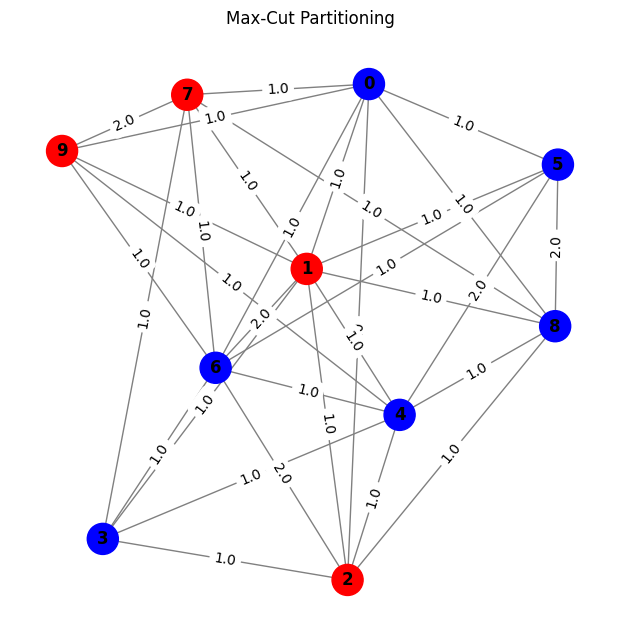

In [ ]:
# @title 🖱 Click to show graph 👀
# Función para visualizar el grafo con la solución de Max-Cut
def plot_max_cut(matrix, bitstring):
    G = nx.Graph()
    n = len(matrix)

    # Agregar nodos y colorearlos según la partición
    color_map = ['red' if bitstring[i] == 1 else 'blue' for i in range(n)]

    for i in range(n):
        for j in range(i+1, n):
            if matrix[i, j] != 0:  # Solo agregar aristas con peso no nulo
                G.add_edge(i, j, weight=matrix[i, j])

    pos = nx.spring_layout(G, seed=42)  # Layout para la disposición de nodos
    weights = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_color=color_map, edge_color='gray', node_size=500, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)

    plt.title("Max-Cut Partitioning")
    plt.show()

# Supongamos que estos son los resultados obtenidos
bitstring = bit  # Ejemplo de partición
cut_value = valor

# Mostrar los resultados con contexto
print(f"Cut energy (value of the found partition): {cut_value}")
print(f"Bitstring of the found partition: {bitstring}")


# Visualizar el grafo y la partición obtenida
plot_max_cut(matrix, bitstring)
